In [2]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
import pandas as pd
from glob import glob
from IPython.core.display import Image, display
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline

from sklearn.metrics import classification_report

from keras import models, layers, optimizers
from keras.preprocessing import image
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint
from tqdm import tqdm
import math
import pickle
import os
from PIL import ImageFile
import time

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
# from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [3]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    """Returns the path and the Label from the folder"""
    data = load_files(path)
    chest_files = np.array(data['filenames'])
    chest_targets = np_utils.to_categorical(np.array(data['target']), 2)
    return chest_files, chest_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../imgs/images/train')
test_files, test_targets = load_dataset('../imgs/images/test')

# load list of dog names
labels = [item[21:-1] for item in sorted(glob("../imgs/images/train/*/"))]
CLASSES = len(labels)

In [4]:
train_RESNET = np.load('bottleneck_features_train.npy')
test_RESNET = np.load('bottleneck_features_test.npy')

In [24]:
test_RESNET.shape

(960, 7, 7, 2048)

In [5]:
# Define the architecture
ChestRESN50_model = Sequential()
ChestRESN50_model.add(Flatten(input_shape=train_RESNET.shape[1:]))
# ChestRESN50_model.add(GlobalAveragePooling2D(input_shape=(train_RESNET.shape[1:])))

ChestRESN50_model.add(layers.Dense(256))
ChestRESN50_model.add(layers.BatchNormalization())
ChestRESN50_model.add(layers.Activation('relu'))
ChestRESN50_model.add(layers.Dropout(0.5))

ChestRESN50_model.add(layers.Dense(CLASSES))
ChestRESN50_model.add(layers.BatchNormalization())
ChestRESN50_model.add(layers.Activation('softmax'))

ChestRESN50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               25690368  
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
_________________________________________________________________
batch_normalization_2 (Batch (None, 2)                 8         
__________

In [7]:
# Compile the model
adam = optimizers.Adam(lr=0.0001)
ChestRESN50_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [8]:
train_RESNET.shape, train_targets.shape, test_RESNET.shape, test_targets.shape

((4020, 7, 7, 2048), (4032, 2), (960, 7, 7, 2048), (967, 2))

In [10]:
# Train the model with with the best weights.

# used to save the model that attains the best validation loss
checkpointer = ModelCheckpoint(filepath='weights.best.RESN50.hdf5', verbose=1, save_best_only=True)

History = ChestRESN50_model.fit(train_RESNET, train_targets[:4020], 
          validation_split = 0.2,
          epochs=10, batch_size=30, callbacks=[checkpointer], verbose=1, shuffle=False)

Train on 3216 samples, validate on 804 samples
Epoch 1/10
3216/3216 [==============================] - ETA: 8:55 - loss: 0.7789 - acc: 0.566 - ETA: 5:06 - loss: 0.9004 - acc: 0.466 - ETA: 3:47 - loss: 0.8376 - acc: 0.488 - ETA: 3:07 - loss: 0.8359 - acc: 0.483 - ETA: 2:42 - loss: 0.8758 - acc: 0.466 - ETA: 2:26 - loss: 0.8525 - acc: 0.483 - ETA: 2:15 - loss: 0.8296 - acc: 0.490 - ETA: 2:05 - loss: 0.8176 - acc: 0.491 - ETA: 1:58 - loss: 0.7946 - acc: 0.511 - ETA: 1:52 - loss: 0.7901 - acc: 0.506 - ETA: 1:46 - loss: 0.7902 - acc: 0.490 - ETA: 1:41 - loss: 0.7913 - acc: 0.477 - ETA: 1:37 - loss: 0.7808 - acc: 0.487 - ETA: 1:34 - loss: 0.7774 - acc: 0.485 - ETA: 1:31 - loss: 0.7782 - acc: 0.482 - ETA: 1:28 - loss: 0.7731 - acc: 0.487 - ETA: 1:26 - loss: 0.7686 - acc: 0.496 - ETA: 1:23 - loss: 0.7691 - acc: 0.488 - ETA: 1:21 - loss: 0.7667 - acc: 0.487 - ETA: 1:19 - loss: 0.7614 - acc: 0.490 - ETA: 1:17 - loss: 0.7614 - acc: 0.488 - ETA: 1:16 - loss: 0.7576 - acc: 0.490 - ETA: 1:15 - loss:

3216/3216 [==============================] - ETA: 1:11 - loss: 0.6913 - acc: 0.700 - ETA: 1:11 - loss: 0.6543 - acc: 0.650 - ETA: 1:12 - loss: 0.6491 - acc: 0.655 - ETA: 1:12 - loss: 0.6537 - acc: 0.641 - ETA: 1:10 - loss: 0.6493 - acc: 0.660 - ETA: 1:09 - loss: 0.6537 - acc: 0.650 - ETA: 1:07 - loss: 0.6479 - acc: 0.666 - ETA: 1:06 - loss: 0.6514 - acc: 0.658 - ETA: 1:05 - loss: 0.6615 - acc: 0.633 - ETA: 1:04 - loss: 0.6636 - acc: 0.626 - ETA: 1:03 - loss: 0.6627 - acc: 0.633 - ETA: 1:03 - loss: 0.6590 - acc: 0.633 - ETA: 1:01 - loss: 0.6634 - acc: 0.625 - ETA: 1:01 - loss: 0.6678 - acc: 0.614 - ETA: 1:00 - loss: 0.6712 - acc: 0.613 - ETA: 1:00 - loss: 0.6699 - acc: 0.614 - ETA: 59s - loss: 0.6695 - acc: 0.615 - ETA: 59s - loss: 0.6705 - acc: 0.61 - ETA: 59s - loss: 0.6679 - acc: 0.61 - ETA: 58s - loss: 0.6645 - acc: 0.62 - ETA: 57s - loss: 0.6642 - acc: 0.62 - ETA: 57s - loss: 0.6638 - acc: 0.62 - ETA: 56s - loss: 0.6642 - acc: 0.62 - ETA: 56s - loss: 0.6667 - acc: 0.61 - ETA: 55s -

3216/3216 [==============================] - ETA: 1:13 - loss: 0.6614 - acc: 0.633 - ETA: 1:16 - loss: 0.6647 - acc: 0.583 - ETA: 1:14 - loss: 0.6596 - acc: 0.588 - ETA: 1:14 - loss: 0.6604 - acc: 0.608 - ETA: 1:15 - loss: 0.6486 - acc: 0.620 - ETA: 1:15 - loss: 0.6523 - acc: 0.611 - ETA: 1:14 - loss: 0.6493 - acc: 0.609 - ETA: 1:14 - loss: 0.6480 - acc: 0.637 - ETA: 1:13 - loss: 0.6540 - acc: 0.625 - ETA: 1:12 - loss: 0.6601 - acc: 0.616 - ETA: 1:11 - loss: 0.6610 - acc: 0.612 - ETA: 1:10 - loss: 0.6529 - acc: 0.619 - ETA: 1:09 - loss: 0.6559 - acc: 0.605 - ETA: 1:08 - loss: 0.6556 - acc: 0.614 - ETA: 1:06 - loss: 0.6575 - acc: 0.608 - ETA: 1:05 - loss: 0.6544 - acc: 0.612 - ETA: 1:04 - loss: 0.6516 - acc: 0.621 - ETA: 1:03 - loss: 0.6487 - acc: 0.625 - ETA: 1:02 - loss: 0.6472 - acc: 0.629 - ETA: 1:01 - loss: 0.6425 - acc: 0.635 - ETA: 1:01 - loss: 0.6428 - acc: 0.634 - ETA: 1:00 - loss: 0.6427 - acc: 0.634 - ETA: 1:00 - loss: 0.6441 - acc: 0.634 - ETA: 59s - loss: 0.6454 - acc: 0.63

3216/3216 [==============================] - ETA: 1:14 - loss: 0.6500 - acc: 0.700 - ETA: 1:14 - loss: 0.6399 - acc: 0.666 - ETA: 1:14 - loss: 0.6382 - acc: 0.644 - ETA: 1:14 - loss: 0.6240 - acc: 0.683 - ETA: 1:14 - loss: 0.6227 - acc: 0.660 - ETA: 1:15 - loss: 0.6309 - acc: 0.644 - ETA: 1:13 - loss: 0.6352 - acc: 0.633 - ETA: 1:11 - loss: 0.6297 - acc: 0.650 - ETA: 1:11 - loss: 0.6395 - acc: 0.625 - ETA: 1:09 - loss: 0.6474 - acc: 0.616 - ETA: 1:09 - loss: 0.6461 - acc: 0.615 - ETA: 1:07 - loss: 0.6391 - acc: 0.622 - ETA: 1:06 - loss: 0.6499 - acc: 0.612 - ETA: 1:05 - loss: 0.6435 - acc: 0.611 - ETA: 1:04 - loss: 0.6467 - acc: 0.606 - ETA: 1:03 - loss: 0.6421 - acc: 0.620 - ETA: 1:02 - loss: 0.6366 - acc: 0.623 - ETA: 1:02 - loss: 0.6319 - acc: 0.633 - ETA: 1:02 - loss: 0.6284 - acc: 0.642 - ETA: 1:01 - loss: 0.6196 - acc: 0.651 - ETA: 1:01 - loss: 0.6225 - acc: 0.647 - ETA: 1:00 - loss: 0.6194 - acc: 0.654 - ETA: 59s - loss: 0.6213 - acc: 0.650 - ETA: 58s - loss: 0.6237 - acc: 0.64 

3216/3216 [==============================] - ETA: 1:13 - loss: 0.7104 - acc: 0.666 - ETA: 1:13 - loss: 0.7356 - acc: 0.583 - ETA: 1:14 - loss: 0.6905 - acc: 0.622 - ETA: 1:14 - loss: 0.6558 - acc: 0.650 - ETA: 1:13 - loss: 0.6410 - acc: 0.666 - ETA: 1:12 - loss: 0.6294 - acc: 0.677 - ETA: 1:11 - loss: 0.6189 - acc: 0.700 - ETA: 1:11 - loss: 0.6177 - acc: 0.695 - ETA: 1:10 - loss: 0.6258 - acc: 0.688 - ETA: 1:09 - loss: 0.6297 - acc: 0.673 - ETA: 1:09 - loss: 0.6186 - acc: 0.678 - ETA: 1:07 - loss: 0.6083 - acc: 0.688 - ETA: 1:06 - loss: 0.6156 - acc: 0.676 - ETA: 1:05 - loss: 0.6091 - acc: 0.681 - ETA: 1:04 - loss: 0.6134 - acc: 0.682 - ETA: 1:03 - loss: 0.6102 - acc: 0.687 - ETA: 1:02 - loss: 0.6042 - acc: 0.694 - ETA: 1:01 - loss: 0.6014 - acc: 0.696 - ETA: 1:01 - loss: 0.6018 - acc: 0.696 - ETA: 1:00 - loss: 0.5899 - acc: 0.705 - ETA: 1:00 - loss: 0.5959 - acc: 0.692 - ETA: 59s - loss: 0.5931 - acc: 0.692 - ETA: 58s - loss: 0.5933 - acc: 0.69 - ETA: 58s - loss: 0.5924 - acc: 0.69 - 

In [13]:
### Load the model weights with the best validation loss.
ChestRESN50_model.load_weights('weights.best.RESN50.hdf5')

### Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
predictions = [np.argmax(ChestRESN50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_RESNET]

# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1)[:960])/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 66.1458%


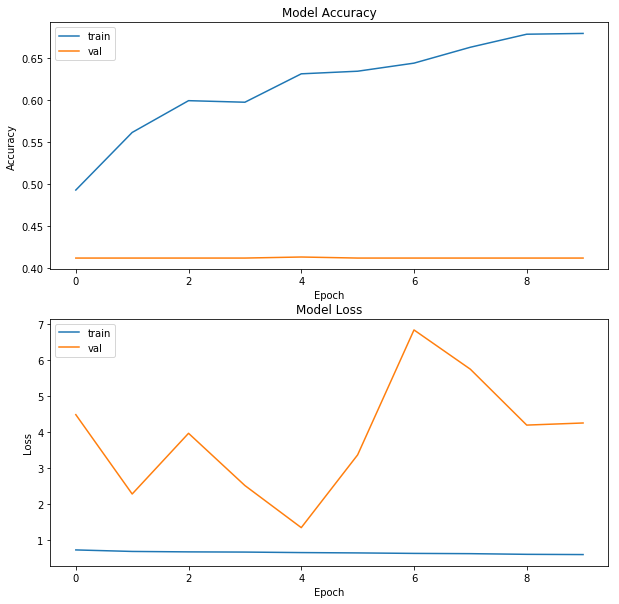

In [14]:
plt.figure(1, figsize=(10,10))  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(History.history['acc'])  
plt.plot(History.history['val_acc'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'val'], loc='upper left')  

# summarize history for loss  

plt.subplot(212)  
plt.plot(History.history['loss'])  
plt.plot(History.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'val'], loc='upper left')  
plt.show()

In [17]:
y_true.shape

(967,)

In [18]:
# Classification Report
y_true = np.argmax(test_targets, axis=1)
print(classification_report(y_true[:960], predictions, target_names=labels))

C:\Users\micka\Anaconda3\envs\tensorflow-sessions\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

     Finding       0.66      1.00      0.80       635
  No Finding       0.00      0.00      0.00       325

   micro avg       0.66      0.66      0.66       960
   macro avg       0.33      0.50      0.40       960
weighted avg       0.44      0.66      0.53       960

